# 1. 预处理

In [2]:
import os, sys
import json
import random
import pickle
from pathlib import Path
from torchcodec.decoders import VideoDecoder
from PIL import Image
from torchvision.utils import flow_to_image
import torch
from torchvision.transforms.v2.functional import to_pil_image
import matplotlib.pyplot as plt
from IPython.display import Video, display
import numpy as np
import imageio

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from evaluate import (
    VideoClip,
    get_saliency_score,
    get_motion_score,
    get_embeddings_score,
    cosine_similarity
)

In [3]:
def plot(imgs):
    fig, axes = plt.subplots(nrows=len(imgs), ncols=len(imgs[0]), figsize=(len(imgs[0])*3, len(imgs)*2))
    axes = np.array(axes).reshape(len(imgs), len(imgs[0]))
    for i in range(len(imgs)):
        for j in range(len(imgs[i])):
            axes[i][j].imshow(imgs[i][j])
            axes[i][j].axis('off')
    plt.tight_layout(pad=0.5)
    plt.show()

def get_imgs(decoder, clip: VideoClip, frame_type: int):
    if frame_type == 0:
        frame = clip.start_frame
        saliency = clip.start_saliency
        flow = clip.start_flow
    elif frame_type == 1:
        frame = clip.end_frame
        saliency = clip.end_saliency
        flow = clip.end_flow
    else:
        raise ValueError()
        
    sim = Image.fromarray(saliency*255).convert('RGB')
    sim = sim.resize((decoder.metadata.width, decoder.metadata.height),resample=Image.BILINEAR)
    fim = Image.fromarray(flow_to_image(torch.tensor(flow)).permute(1, 2, 0).numpy()).convert('RGB')
    fim = fim.resize((decoder.metadata.width, decoder.metadata.height),resample=Image.BILINEAR)
    return [to_pil_image(decoder[frame]), sim, fim]

def show_clips(decoder1, decoder2, clip1, clip2, fps = None):
    if not fps:
        fps = decoder1.metadata.average_fps
    all_frames = []
    all_frames.extend(decoder1[clip1.start_frame : clip1.end_frame + 1])
    all_frames.extend(decoder2[clip2.start_frame : clip2.end_frame + 1])

    frames_tensor = torch.stack(all_frames)
    
    frames_np = frames_tensor.permute(0, 2, 3, 1).cpu().numpy()

    imageio.mimwrite("temp_video.mp4", frames_np, fps=fps, quality=8, macro_block_size=None)
    
    # 展示视频
    display(Video("temp_video.mp4", embed=True, width=300))

In [4]:
jsonl_path = Path("../data/json/mashup.json")
output_root = Path("../output/videos/mashup/")

videos = []
with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        item = json.loads(line)
        videos.append({
            "video_id": item["video_id"],
            "shots": item["shots"]
        })

print(f"共加载 {len(videos)} 个视频")

# 提前加载所有 clips.pkl 文件
video_clips_dict = {}
valid_videos = []
total_shots = 0
for video in videos:
    video_id = video["video_id"]
    if video_id != "NsMtId_KZY8":
        continue 
    video_clips_path = output_root / f"{video_id}/clips.pkl"
    if not video_clips_path.exists():
        # print(f"未找到 {video_clips_path}，跳过该视频")
        continue
    with open(video_clips_path, "rb") as f:
        video_clips_dict[video_id] = pickle.load(f)
    valid_videos.append(video)
    total_shots += len(video["shots"])

videos = valid_videos
print(f"已加载 {len(video_clips_dict)} 个视频的 clips.pkl 文件")
print(f"共 {total_shots} 个镜头")

共加载 615 个视频
已加载 1 个视频的 clips.pkl 文件
共 800 个镜头


# 2. 检索

In [5]:
semantic_weight = 0.1
motion_weight = 0.8
saliency_weight = 0.1

def get_similarity_score(shot_feature1, shot_feature2):
    semantic_score = get_embeddings_score(shot_feature1, shot_feature2)
    motion_score = get_motion_score(shot_feature1, shot_feature2)
    saliency_score = get_saliency_score(shot_feature1, shot_feature2)
    # motion_score = 0
    
    total_score = (semantic_weight * semantic_score +
                   motion_weight * motion_score +
                   saliency_weight * saliency_score)
    return total_score

In [12]:
def _extract_top_flows(flow_field, top_ratio):
    u = flow_field[0].reshape(-1)
    v = flow_field[1].reshape(-1)
    mag = np.sqrt(u**2 + v**2)
    k = max(1, int(len(mag) * top_ratio))
    idx = np.argpartition(mag, -k)[-k:]
    top_u = u[idx]
    top_v = v[idx]
    return (np.mean(top_u), np.mean(top_v))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_motion_score(clip1, clip2, top_ratio=0.05, conf_ratio = 2.0, debug = False):    
    (u1, v1) = _extract_top_flows(clip1.end_flow, top_ratio)
    (u2, v2) = _extract_top_flows(clip2.start_flow, top_ratio)
    m1 = np.sqrt(u1**2+v1**2)
    m2 = np.sqrt(u2**2+v2**2)
    mag_sim = 1 - np.tanh(np.abs(m1 - m2) / 80.0)
    dir_sim = np.abs((u1 * u2 + v1 * v2) / (m1 * m2))
    dir_conf = (m1 / (m1 + 2)) * (m2 / (m2 + 2))
    # dir_conf = sigmoid((m1 - 8) / 2) * sigmoid((m2 - 8) / 2)

    if debug:
        print(u1, v1, u2, v2)
        print(m1, m2)
        print(mag_sim, dir_sim, dir_conf)
    return mag_sim * (1 - dir_conf) + dir_sim * dir_conf


查询的 shot 来自视频 NsMtId_KZY8 的第 431 个 shot
最相似的 shot 来自视频 NsMtId_KZY8 的第 429 个 shot， 相似度得分为 0.9781
语义相似度：0.9678
-4.3995047 0.4908355 -3.4136937 0.5421707
4.4268003 3.4564798
0.9878716 0.9989237 0.43633148
运动相似度：0.9927
显著性相似度：0.8716


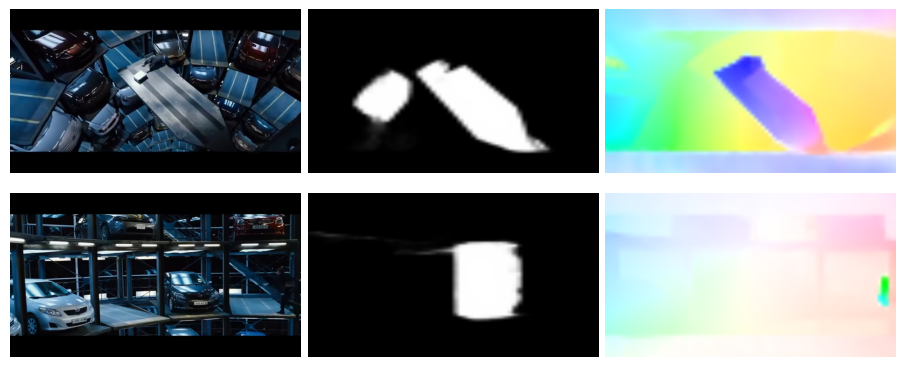

In [20]:
# 指定一个 shot（如果未指定则随机选取）

video_id = random.choice(videos)["video_id"]
clips = video_clips_dict[video_id]

shot_index = random.randint(0, len(clips) - 1)

# video_id = None  # 用户可以手动指定 video_id
# shot_index = 706  # 用户可以手动指定 clip 索引


selected_shot_feature = clips[shot_index]

# 枚举所有视频的其他 shots
most_similar_shot = None
highest_similarity = float("-inf")

for video in videos:
    other_video_id = video["video_id"]
    other_clips = video_clips_dict[other_video_id]
    for other_shot_feature in other_clips:
        if other_video_id == video_id and other_shot_feature == selected_shot_feature:
            continue  # 跳过同一个 shot
        # if other_video_id == video_id:
        #     continue  # 跳过当前视频

        similarity = get_similarity_score(selected_shot_feature, other_shot_feature) 

        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_shot = {
                "video_id": other_video_id,
                "shot_index": other_clips.index(other_shot_feature),
                "shot_feature": other_shot_feature
            }

print(f"查询的 shot 来自视频 {video_id} 的第 {shot_index} 个 shot")
print(f"最相似的 shot 来自视频 {most_similar_shot['video_id']} 的第 {most_similar_shot['shot_index']} 个 shot， 相似度得分为 {highest_similarity:.4f}")
print(f"语义相似度：{get_embeddings_score(selected_shot_feature, most_similar_shot['shot_feature']):.4f}")
print(f"运动相似度：{get_motion_score(selected_shot_feature, most_similar_shot['shot_feature'], debug=True):.4f}")
print(f"显著性相似度：{get_saliency_score(selected_shot_feature, most_similar_shot['shot_feature']):.4f}")

decoder1 = VideoDecoder(Path(f"../data/videos/mashup/{video_id}/video.mp4"))
decoder2 = VideoDecoder(Path(f"../data/videos/mashup/{most_similar_shot['video_id']}/video.mp4"))
img1 = get_imgs(decoder1, selected_shot_feature, 1)  
img2 = get_imgs(decoder2, most_similar_shot['shot_feature'], 0) 
plot([img1, img2])
show_clips(decoder1, decoder2, selected_shot_feature, most_similar_shot['shot_feature'])